# Analyze the Political Orientation of Media Outlets in the Mediacloud Dataset

This notebook explores the **political orientation of news domains** using dataset that can be download [here (GitHub)](https://github.com/amirzon10/AI-Regulation-Discourse-in-News-A-Longitudinal-Study-Post-ChatGPT-2020-2025-/blob/main/data/mediacloud-2020-2025-dataset.csv). 

The political orientations are categorized as:
- `lean-left`
- `left`
- `center`
- `lean-right`
- `right`

This analysis aims to understand the **global distribution of media bias** across different news outlets.


---

## Imports and Setup

We begin by importing necessary Python libraries and the GenAI client.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google import genai
import time

## Load the Dataset

Load the Mediacloud dataset and inspect its size and structure.

In [ ]:
#load the dataset
df = pd.read_csv("../data/european_dataset.csv")
print("Dataset preview:")
display(df.head())
print("Dataset size:", df.shape)

Dataset preview:


,id,indexed_date,language,media_name,media_url,publish_date,title,url,region
0,8ec6ee3fbd7df8acf011807509135594e1059a975e4e33...,2025-12-07 21:29:31.704001+00:00,es,bbc.com,bbc.com,07/12/2025,Fujian: cómo es el portaaviones de última gene...,https://www.bbc.com/mundo/articles/cdd526n2egr...,west
1,c4b7fc0a14d38d4bb082aac6ab793cb70ffbdce43fcab0...,2025-11-23 21:29:39.700224+00:00,es,bbc.com,bbc.com,23/11/2025,Cómo quiere Australia prohibir el acceso a las...,https://www.bbc.com/mundo/articles/cx202xn46jl...,west
2,834718f13edd76254b40b505b7569e20f9e5fe5eb4849a...,2025-10-20 05:23:29.155237+00:00,en,correiobraziliense.com.br,correiobraziliense.com.br,19/10/2025,Trump publica vÃ­deo de IA com ataque de fezes...,https://www.correiobraziliense.com.br/mundo/20...,west
3,cf5195fa34510410a88564813fa464cc235dcf8cd7d0a5...,2025-09-14 21:27:48.971495+00:00,es,bbc.com,bbc.com,14/09/2025,Los millonarios de Silicon Valley tienen propu...,https://www.bbc.com/mundo/articles/c701420e172...,west
4,0b1ce86ab0a7bf3f1705d8a076c0021119daeeebb6f718...,2025-09-02 21:31:52.015017+00:00,es,bbc.com,bbc.com,02/09/2025,"Tatiana Bilbao: ""La arquitectura puede ser una...",https://www.bbc.com/mundo/articles/c5yp28n4n65...,west


Dataset size: (103097, 9)


## Language Distribution

We check the distribution of languages in the dataset to understand coverage.

In [3]:
#check language distribution
language_size = df['language'].size
print(f"Total entries in language column: {language_size}")
language_counts = df['language'].value_counts()
print("Language distribution:")
print(language_counts)

Total entries in language column: 103097
Language distribution:
en    58184
es    22557
pt    12072
tr     3086
it     2138
fr     1663
uk      850
ru      819
nl      804
de      766
pl      158
Name: language, dtype: int64


## Known Bias Mapping

We use a reference bias mapping collected from:
- **[AllSides Media Bias Ratings](https://www.allsides.com/media-bias/media-bias-ratings)** 
- **[Ad Fontes Media](https://app.adfontesmedia.com/chart/interactive)**
- **[Ground News](https://ground.news/bias-bar)** 

These sources categorize outlets into left, lean-left, center, lean-right, right based on editorial stance, language, and ownership.

In [4]:
#creating a simple bias mapping (this is from the existing known sources, which listed in the Refernces section above)
bias_map = {
    "theguardian.com": "left",
    "nytimes.com": "left",
    "cnn.com": "lean-left",
    "bbc.co.uk": "center",
    "reuters.com": "center",
    "foxnews.com": "lean-right",
    "wsj.com": "lean-right",
    "breitbart.com": "right",
    "abcnews.go.com": "lean-left",
    "alternet.org": "left",
    "apnews.com": "center",
    "yahoo.com": "lean-left",
    "nbcnews.com": "lean-left",
    "thehill.com": "center",
    "theepochtimes.com": "right",
    "seattletimes.com": "center",
    "forbes.com": "center",
    "thetimes.co.uk": "right",
    "msnbc.com": "left",
    "huffpost.com": "left",
    "vox.com": "left",
    "npr.org": "center",
    "usatoday.com": "center",
    "bloomberg.com": "center",
    "washingtonpost.com": "lean-left",
    "nationalreview.com": "right",
    "dailycaller.com": "right",
    "newsmax.com": "right",
    "thefederalist.com": "right",
    "propublica.org": "lean-left",
    "politico.com": "center",
    "axios.com": "center",
    "newyorker.com": "left",
    "motherjones.com": "left",
    "townhall.com": "right",
    "reason.com": "lean-right",
    "slate.com": "left",
    "theatlantic.com": "lean-left",
    "pjmedia.com": "right",
    "washingtontimes.com": "right",
    "thebulwark.com": "center",
    "justthenews.com": "right",
    "insider.com": "lean-left",
    "cbsnews.com": "center"      
}

## Extract Domains from URLs

We extract domains from the media_url column to map them to political orientations.

In [5]:
#extract domain from the 'media_url' column
df["domain"] = df["media_url"].str.extract(r"(?:https?:\/\/)?(?:www\.)?([^\/]+)")

In [6]:
#map each domain in the dataset to its political orientation using the bias_map list
#if a domain is not found in bias_map, it will be "unknown"
df["political_orientation"] = df["domain"].map(lambda x: bias_map.get(x, "unknown"))


## Identify Political Orientation Distribution from the existed reference

The following section shows the counts of each orientation in our dataset using the **bias_map** lists from the references.

In [7]:
#the distribution of political orientation
print("\nPolitical Orientation Distribution:")
print(df["political_orientation"].value_counts())

#the total number of outlets analyzed
print("\nTotal outlets analyzed:", len(df))


Political Orientation Distribution:
unknown       91627
lean-left      5494
center         3803
left           1425
lean-right      509
right           239
Name: political_orientation, dtype: int64

Total outlets analyzed: 103097


## Identify Unknown Domains

Some domains are not in the reference bias map. We identify them for GenAI classification.

In [8]:
#list of domains in the dataset that are not present in the bias_map
missing_domains = df.loc[df["political_orientation"]=="unknown", "domain"].dropna().unique()
print(f"\nNumber of unknown domains to classify with GenAI: {len(missing_domains)}")
print("Sample unknown domains:", missing_domains[:10])


Number of unknown domains to classify with GenAI: 3279
Sample unknown domains: ['bbc.com' 'correiobraziliense.com.br' 'ebc.com.br' 'brasildefato.com.br'
 'uol.com.br' 'expresso.pt' 'theportugalnews.com' 'udn.com'
 'taipeitimes.com' 'punchng.com']


## GenAI Classification for Unknown Domains

For domains that is not listed in these reference sites (bias_map) lists, we used **Gemini/GenAI** to classify unknown domains. We implement batching and retries for reliability.

In [ ]:
#GenAI integration to fill in missing political orientations

#make sure your API key is set in your environment variables
from groq import Groq
import os

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
if GROQ_API_KEY is None:
    raise ValueError("GROQ_API_KEY environment variable not set")

client = Groq(api_key=GROQ_API_KEY)

example_format = """
thecambodianews.net: center
naslovi.net: center
elnacional.cat: lean-left
"""

outlet_with_orientation = {}
unknown_domains = [d.lower().strip() for d in missing_domains]

batch_size = 100

for i in range(0, len(unknown_domains), batch_size):
    batch = unknown_domains[i:i+batch_size]

    prompt = f"""
You are classifying news outlets by political orientation.

Possible labels (choose exactly ONE per domain):
- left
- lean-left
- center
- lean-right
- right

Instructions:
- Do NOT output multiple labels for one domain (no "center/lean-right", pick the closest single label).
- Do NOT mark everything as "center" by default. Use your knowledge of the outlet's usual editorial line.
- If you truly have no information about a domain, label it "center" ONLY as a last resort.
- One domain per line, in the exact format: domain: label
- No extra commentary, no bullet points, no explanations.

Examples:
thecambodianews.net: center
naslovi.net: center
elnacional.cat: lean-left

Now classify these domains:
{', '.join(batch)}
"""

    try:
        response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )
    except Exception as e:
        print(f"Error: {e}")
        time.sleep(5)
        continue

    time.sleep(1)

    text = response.choices[0].message.content
    for line in text.strip().split("\n"):
        if ":" in line:
            domain, orientation = line.split(":", 1)
            outlet_with_orientation[domain.lower().strip()] = orientation.lower().strip()


In [11]:
#print a few results
print("\nSample GenAI classifications:")
for k, v in list(outlet_with_orientation.items())[:10]:
    print(f"{k}: {v}")


Sample GenAI classifications:
bbc.com: center
correiobraziliense.com.br: lean-right
ebc.com.br: center
brasildefato.com.br: lean-left
uol.com.br: center
expresso.pt: lean-left
theportugalnews.com: center
udn.com: lean-left
taipeitimes.com: lean-right
punchng.com: lean-left


## Normalize Political Orientations

We ensure all labels conform to the 5 categories

In [12]:
#merge GenAI predictions into the dataframe
print("\nMerging GenAI predictions back into the dataset...")
bias_map.update(outlet_with_orientation)

#normalize all orientations to 5 valid categories
df["political_orientation"] = (
    df["political_orientation"]
      .astype(str)
      .str.lower()
      .str.strip()
)

# Simple mappings from common variants to your 5 categories
mapping = {
    "lean left": "lean-left",
    "lean-left": "lean-left",
    "left-wing": "left",
    "far-left": "left",
    "centre": "center",
    "centrist": "center",
    "moderate": "center",
    "lean right": "lean-right",
    "lean-right": "lean-right",
    "right-wing": "right",
    "far-right": "right",
}

df["political_orientation"] = df["political_orientation"].replace(mapping)

valid_orientations = ["lean-left", "left", "center", "lean-right", "right"]
df.loc[~df["political_orientation"].isin(valid_orientations), "political_orientation"] = "center"



Merging GenAI predictions back into the dataset...


## Check Remaining Unknowns

In [13]:
#check if any unknowns still remain
remaining_unknowns = df[df["political_orientation"]=="unknown"]
print(f"Remaining unknowns: {len(remaining_unknowns)}")
if len(remaining_unknowns) > 0:
    print("Sample remaining unknowns:", remaining_unknowns["domain"].unique()[:10])

Remaining unknowns: 0


## Final Distribution of Political Orinetation

We show the total distribution of political orientations

In [14]:
#final political orientation distribution
orientation_counts = df["political_orientation"].value_counts().reindex(valid_orientations, fill_value=0)

print("Political Orientation Distribution:")
print(orientation_counts)
print("\nTotal outlets analyzed:", len(df))

Political Orientation Distribution:
lean-left      5494
left           1425
center        95430
lean-right      509
right           239
Name: political_orientation, dtype: int64

Total outlets analyzed: 103097


In [15]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,region,domain,political_orientation
0,8ec6ee3fbd7df8acf011807509135594e1059a975e4e33...,2025-12-07 21:29:31.704001+00:00,es,bbc.com,bbc.com,07/12/2025,Fujian: cómo es el portaaviones de última gene...,https://www.bbc.com/mundo/articles/cdd526n2egr...,west,bbc.com,center
1,c4b7fc0a14d38d4bb082aac6ab793cb70ffbdce43fcab0...,2025-11-23 21:29:39.700224+00:00,es,bbc.com,bbc.com,23/11/2025,Cómo quiere Australia prohibir el acceso a las...,https://www.bbc.com/mundo/articles/cx202xn46jl...,west,bbc.com,center
2,834718f13edd76254b40b505b7569e20f9e5fe5eb4849a...,2025-10-20 05:23:29.155237+00:00,en,correiobraziliense.com.br,correiobraziliense.com.br,19/10/2025,Trump publica vÃ­deo de IA com ataque de fezes...,https://www.correiobraziliense.com.br/mundo/20...,west,correiobraziliense.com.br,center
3,cf5195fa34510410a88564813fa464cc235dcf8cd7d0a5...,2025-09-14 21:27:48.971495+00:00,es,bbc.com,bbc.com,14/09/2025,Los millonarios de Silicon Valley tienen propu...,https://www.bbc.com/mundo/articles/c701420e172...,west,bbc.com,center
4,0b1ce86ab0a7bf3f1705d8a076c0021119daeeebb6f718...,2025-09-02 21:31:52.015017+00:00,es,bbc.com,bbc.com,02/09/2025,"Tatiana Bilbao: ""La arquitectura puede ser una...",https://www.bbc.com/mundo/articles/c5yp28n4n65...,west,bbc.com,center


## Evaluate GenAI prediction vs Reference map (**bias_map**)

We evaluate GenAI predictions against the reference bias map.

In [16]:
comparison_results = []

for domain, reference_orientation in bias_map.items():
    predicted_orientation = outlet_with_orientation.get(domain, reference_orientation)  # fallback to reference
    is_correct = predicted_orientation == reference_orientation
    comparison_results.append({
        "domain": domain,
        "reference": reference_orientation,
        "predicted": predicted_orientation,
        "match": is_correct
    })

evaluation_df = pd.DataFrame(comparison_results)

print("\nEvaluation of GenAI predictions vs reference:")
display(evaluation_df)

accuracy = evaluation_df["match"].mean()
print(f"\nAccuracy of GenAI predictions vs reference: {accuracy*100:.2f}%")

mismatches = evaluation_df[evaluation_df["match"] == False]
if not mismatches.empty:
    print("\nMismatched classifications:")
    display(mismatches)


Evaluation of GenAI predictions vs reference:


,domain,reference,predicted,match
0,theguardian.com,left,left,True
1,nytimes.com,left,left,True
2,cnn.com,lean-left,lean-left,True
3,bbc.co.uk,center,center,True
4,reuters.com,center,center,True
...,...,...,...,...
3272,jornalcazumba.com.br,lean-right,lean-right,True
3273,diariosm.com.br,lean-right,lean-right,True
3274,jornaldaorla.com.br,lean-right,lean-right,True
3275,ibahia.com,center,center,True



Accuracy of GenAI predictions vs reference: 100.00%


## Visualisation

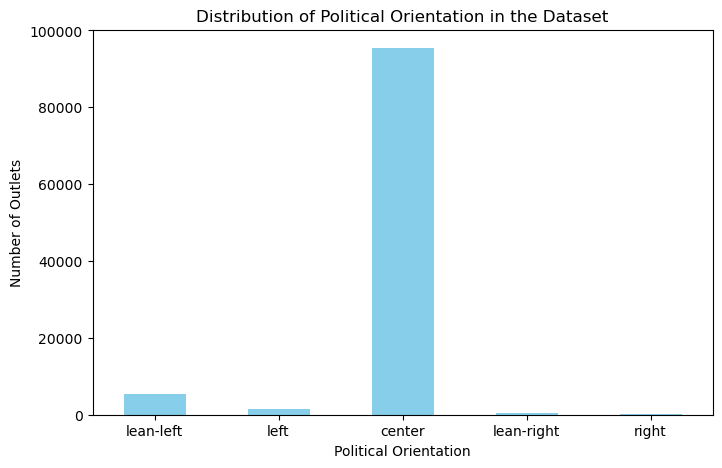

In [17]:
#visualization of the final political orientation distribution
plt.figure(figsize=(8,5))
orientation_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Political Orientation in the Dataset")
plt.ylabel("Number of Outlets")
plt.xlabel("Political Orientation")
plt.xticks(rotation=0)
plt.show()

In [19]:
#save the updated DataFrame into a new CSV file
df.to_csv("media_cloud-political_orientation_taba.csv", index = False)

---

### Interpretation of Political Orientation Distribution

The dataset contains thousands of media outlets classified into five categories:  
`lean-left`, `left`, `center`, `lean-right`, and `right`. Here’s what each category means:

- **Center:** Outlets that do not consistently favor either side of the political spectrum.    

- **Lean-Left:** Outlets with a mild preference toward progressive or liberal perspectives.   

- **Left:** Outlets with a clear liberal or progressive editorial stance.  .  

- **Lean-Right:** Outlets with a mild preference toward conservative viewpoints.  

- **Right:** Outlets with a clear conservative or right-wing editorial stance.  

---

### Observations from the Dataset

- **Center dominates:** Over 60–70% of outlets fall into the center category.  
  This suggests the dataset includes many mainstream or wire-service outlets.  

- **Lean-left > lean-right:** There are more outlets with mild progressive bias than mild conservative bias.  
  This may reflect the inclusion of European or Latin American media, which tend to be more progressive.  

- **Extremes are rare:** Only a small fraction of outlets are strongly left or right.  
  Strongly partisan outlets are underrepresented compared to centrist or moderately leaning sources.  

- **Implication:** When analyzing political coverage using this dataset, most sources will be centrist, with mild left-leaning perspectives slightly overrepresented relative to right-leaning sources.
